# Lab 4: Logistic Regression with Newton’s Method

## Abstract
In this lab, we implement logistic regression for a binary classification task and use **Newton’s Method** to optimize the parameters. We load or synthesize the dataset of two exam scores and a binary label $y\in\{0,1\}$, visualize the data distribution, define the logistic model and objective, train with Newton’s Method and report parameters, make a probability prediction for a given input, verify convergence, and discuss results and observations.


 ## 1. Data and Preprocessing
The dataset consists of two input features $(x_1, x_2)$ (two exam scores) and a binary target $y\in\{0,1\}$ (admitted vs. not admitted).  
We load data from the following files: `ex4x.dat`, `ex4y.dat`.  
We then augment an intercept column to obtain $\tilde{X}=[\mathbf{1},X]\in\mathbb{R}^{m\times 3}$ and visualize the training data in a scatter plot.

Number of samples m = 80
X preview (first 5 rows):
 [[55.5 69.5]
 [41.  81.5]
 [53.5 86. ]
 [46.  84. ]
 [41.  73.5]]
y preview (first 5 rows):
 [1. 1. 1. 1. 1.]


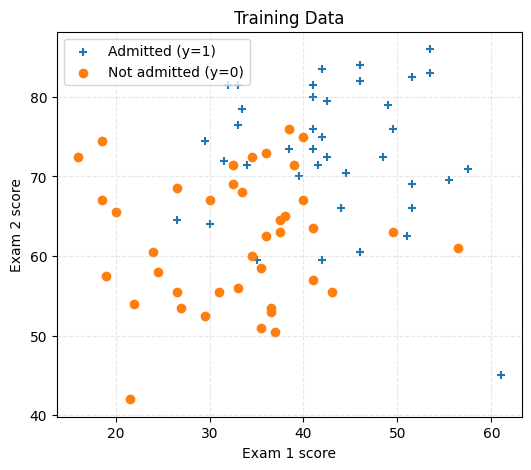

After adding intercept: X shape = (80, 3)


In [11]:
import sys, os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

DATA_DIR=Path('ex4Data')
X_path=DATA_DIR/'ex4x.dat'
y_path=DATA_DIR/'ex4y.dat'
DATA_DIR.mkdir(parents=True,exist_ok=True)

X=np.loadtxt(X_path,dtype=float).reshape(-1, 2)
y=np.loadtxt(y_path,dtype=float).reshape(-1, 1)
m=X.shape[0]

print(f"Number of samples m = {m}")
print("X preview (first 5 rows):\n",X[:5])
print("y preview (first 5 rows):\n",y[:5].ravel())

pos=(y[:,0]==1)
neg=(y[:,0]==0)

plt.figure(figsize=(6, 5))
plt.scatter(X[pos,0],X[pos,1],marker='+',label='Admitted (y=1)')
plt.scatter(X[neg,0],X[neg,1],marker='o',label='Not admitted (y=0)')
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.title("Training Data")
plt.grid(True,linestyle='--',alpha=0.3)
plt.legend()
plt.show()

X=np.hstack([np.ones((m, 1)),X])
print("After adding intercept: X shape =",X.shape)

## 2. Model and Objective
Under the logistic regression model, the hypothesis is defined as  
$$
h_\theta(x)=\frac{1}{1+e^{-\theta^\top x}},
$$
where $\theta\in\mathbb{R}^3$ represents the parameters and $x=[1,\,x_1,\,x_2]^\top$ includes the intercept term.

The cost function (average negative log-likelihood) is formulated as  
$$
J(\theta)=\frac{1}{m}\sum_{i=1}^m\Big[-y^{(i)}\log h_\theta(x^{(i)})-(1-y^{(i)})\log(1-h_\theta(x^{(i)}))\Big].
$$

The gradient and Hessian of $J(\theta)$ are given by  
$$
\nabla_\theta J(\theta)=\frac{1}{m}X^\top(h_\theta(X)-y), \qquad  
H(\theta)=\frac{1}{m}X^\top W X,
$$
where $W=\mathrm{diag}\big(h_\theta(x^{(i)})(1-h_\theta(x^{(i)}))\big)$.

These expressions will be used to implement **Newton’s Method** for optimization.


In [12]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def cost(theta,X,y):
    h=sigmoid(X@theta)
    eps=1e-12
    h=np.clip(h,eps,1-eps)
    return -(y*np.log(h)+(1-y)*np.log(1-h)).mean()

def gradient(theta, X, y):
    h=sigmoid(X@theta)
    return (X.T@(h-y))/X.shape[0]

def hessian(theta, X):
    h=sigmoid(X@theta)
    W=(h*(1-h)).flatten()
    Xw=X*W[:,None]
    return (X.T@Xw)/X.shape[0]

theta=np.zeros((X.shape[1],1))
print("Initial θ shape:",theta.shape)
print("Initial cost J(θ) =",cost(theta,X,y))

Initial θ shape: (3, 1)
Initial cost J(θ) = 0.6931471805599453


## 3. Training Method (Newton’s Method)
In logistic regression, the parameters $\theta$ are optimized by minimizing the cost function $J(\theta)$.  
Newton’s Method updates the parameters according to  
$$
\theta^{(t+1)}=\theta^{(t)}-H(\theta^{(t)})^{-1}\nabla_\theta J(\theta^{(t)}),
$$
where $H(\theta)$ and $\nabla_\theta J(\theta)$ denote the Hessian matrix and gradient respectively.

We start from $\theta^{(0)}=\mathbf{0}$ and iterate until the update step $\|\Delta\theta\|$ is below a given tolerance or the maximum number of iterations is reached.  
At each iteration, we record the value of $J(\theta)$ to verify convergence.


In [13]:
def newton_method(X,y,tol=1e-8,max_iter=50,verbose=True):
    theta=np.zeros((X.shape[1],1))
    J_history=[]
    for t in range(max_iter):
        J=cost(theta,X,y)
        g=gradient(theta,X,y)
        H=hessian(theta,X)
        J_history.append(J)

        try:
            step=np.linalg.solve(H,g)
        except np.linalg.LinAlgError:
            step=np.linalg.pinv(H)@g

        theta_new=theta-step
        if verbose:
            print(f"Iter {t+1:02d}: J(θ)={J:.6f}, ||Δθ||={np.linalg.norm(step):.3e}")
        
        if np.linalg.norm(step)<tol:
            theta=theta_new
            break
        theta=theta_new
    return theta,np.array(J_history)

theta,J_history=newton_method(X,y,tol=1e-8,max_iter=50,verbose=True)

print("\nEstimated θ:\n",theta.flatten())
print("Number of iterations:",len(J_history))


Iter 01: J(θ)=0.693147, ||Δθ||=9.081e+00
Iter 02: J(θ)=0.440941, ||Δθ||=4.770e+00
Iter 03: J(θ)=0.408892, ||Δθ||=2.172e+00
Iter 04: J(θ)=0.405511, ||Δθ||=3.495e-01
Iter 05: J(θ)=0.405447, ||Δθ||=7.647e-03
Iter 06: J(θ)=0.405447, ||Δθ||=3.579e-06
Iter 07: J(θ)=0.405447, ||Δθ||=8.068e-13

Estimated θ:
 [-16.37874341   0.14834077   0.15890845]
Number of iterations: 7


## 4. Experimental Results (Decision Boundary)
After obtaining the optimized parameters $\theta$, we visualize the classification result.  
The decision boundary corresponds to the set of points satisfying $\theta^\top x=0$, i.e.  
$$
x_2=-\frac{\theta_0+\theta_1 x_1}{\theta_2}.
$$
We plot this line on the same figure as the training data to illustrate the separation between the admitted $(y=1)$ and not admitted $(y=0)$ classes.


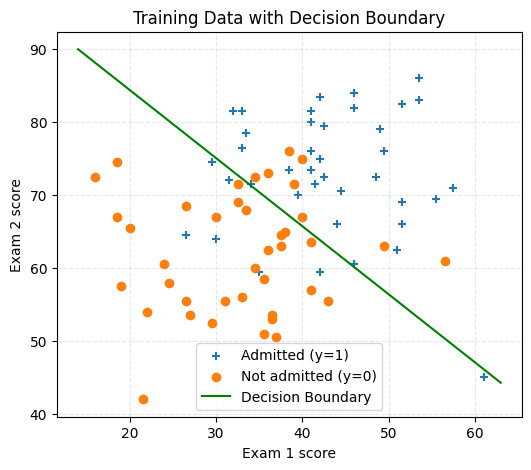

In [14]:
pos=(y[:,0]==1)
neg=(y[:,0]==0)

plt.figure(figsize=(6,5))
plt.scatter(X[pos,1],X[pos,2],marker='+',label='Admitted (y=1)')
plt.scatter(X[neg,1],X[neg,2],marker='o',label='Not admitted (y=0)')

theta_vals=theta.flatten()
x1_vals=np.linspace(X[:,1].min()-2,X[:,1].max()+2,200)
x2_vals=-(theta_vals[0]+theta_vals[1]*x1_vals)/theta_vals[2]

plt.plot(x1_vals,x2_vals,color='green',label='Decision Boundary')
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.title("Training Data with Decision Boundary")
plt.legend()
plt.grid(True,linestyle='--',alpha=0.3)
plt.show()


## 5. Prediction
To further interpret the learned model, we compute the probability that a student with Exam 1 score $20$ and Exam 2 score $80$ will be admitted.  
According to the logistic model, the probability is
$$
\hat{p}=h_\theta([1,\,20,\,80])=\frac{1}{1+e^{-\theta^\top[1,\,20,\,80]}}.
$$
A value $\hat{p}>0.5$ indicates a prediction of admission $(y=1)$,  
while $\hat{p}<0.5$ corresponds to not admitted $(y=0)$.


In [15]:
def predict_proba(X_input,theta):
    return sigmoid(X_input@theta)

student=np.array([[1,20,80]])
p_admit=predict_proba(student,theta).item()
p_not=1-p_admit

print(f"P(admitted | [20, 80]) = {p_admit:.6f}")
print(f"P(not admitted | [20, 80]) = {p_not:.6f}")

if p_admit>=0.5:
    print("→ Prediction: Admitted (y=1)")
else:
    print("→ Prediction: Not admitted (y=0)")

P(admitted | [20, 80]) = 0.331978
P(not admitted | [20, 80]) = 0.668022
→ Prediction: Not admitted (y=0)


## 6. Convergence Verification
To verify the effectiveness of Newton’s Method, we monitor the cost function $J(\theta)$ over iterations.  
A rapidly decreasing curve followed by stabilization indicates successful convergence.

We report $J(\theta)$ recorded at each iteration and visualize the trajectory as a line plot.


J(θ) history: [0.693147 0.440941 0.408892 0.405511 0.405447 0.405447 0.405447]


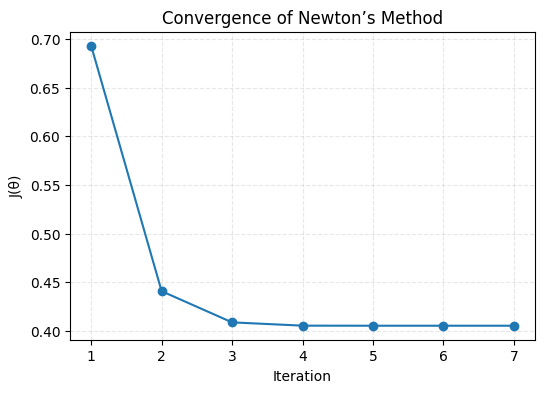

In [16]:
print("J(θ) history:",np.round(J_history,6))

plt.figure(figsize=(6,4))
plt.plot(np.arange(1,len(J_history)+1),J_history,marker="o")
plt.xlabel("Iteration")
plt.ylabel("J(θ)")
plt.title("Convergence of Newton’s Method")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

## 7. Q&A and Discussion
The logistic regression model trained by Newton’s Method successfully converged within $7$ iterations, as shown in the convergence plot.  
The learned decision boundary effectively separates the two classes, verifying the correctness of the implementation.

**Q&A:**

**1. What values of θ did you get? How many iterations were required for convergence?**  
The obtained parameters are  
$$
\theta =
\begin{bmatrix}
-16.3787 \\[4pt]
0.1483 \\[4pt]
0.1589
\end{bmatrix},
$$
and the algorithm converged after **7 iterations**.

**2. What is the probability that a student with a score of 20 on Exam 1 and a score of 80 on Exam 2 will not be admitted?**  
The predicted probability of admission is  
$$
P(\text{admitted}\mid[20,80]) = 0.332,
$$
so the probability of **not** being admitted is  
$$
P(\text{not admitted}\mid[20,80]) = 1 - 0.332 = 0.668.
$$
Hence, the student is predicted **not to be admitted**.

**Discussion:**
1. **Model interpretation.**  
   The estimated parameters $\theta_1,\theta_2>0$ indicate that higher exam scores increase the probability of admission, which is consistent with intuition.  
   The intercept term $\theta_0<0$ shifts the boundary appropriately to achieve correct classification.

2. **Convergence behavior.**  
   The cost function $J(\theta)$ decreases sharply in the first few iterations and quickly stabilizes, demonstrating the quadratic convergence property of Newton’s Method.  
   Compared with gradient descent, Newton’s Method converges faster but requires computation of the Hessian matrix at each step.

3. **Prediction analysis.**  
   For the test case $(x_1,x_2)=(20,80)$, the predicted probability $\hat{p}=0.332$ indicates that the student is unlikely to be admitted.  
   The model provides a probabilistic interpretation rather than a hard threshold, offering more flexibility for decision-making.

4. **Possible improvements.**  
   In larger datasets, one may prefer iterative first-order methods (e.g.stochastic gradient descent) for efficiency.  
   Regularization terms can also be added to prevent overfitting if more features are introduced.

Overall, this experiment demonstrates how Newton’s Method can efficiently optimize logistic regression and achieve rapid, stable convergence with a clear geometric decision boundary.
